<center>
<img src='./img/nsidc_logo.png'/>

# Read and Plot SMAP data using `xarray.DataTree`

</center>
---

## 1. Overview  
In this tutorial, we will read the SMAP data we downloaded the `working_with_smap_in_xarray.ipynb` notebook, read the data into an `xarray.DataTree`, create a map of soil moisture and plot a time-series soil moisture for a location on Earth.

`xarray.DataTree` was created to work with hierachical datasets.  Hierachical datasets are those datasets that use tree-like, nested, directory structures to group and store complex data.  The SMAP Level-3 is a relatively simple hierachical data structure, with only two groups; one group for data from AM satellite overpasses and one group for data from PM satellite overpasses.  To make working with this data easy, we also add meaningful names for the dimensions of the data and geospatial coordinates.  

### **Credits**

This tutorial is based on the notebooks originally provided to NSIDC by Adam Purdy. Jennifer Roebuck of NSIDC updated the tutorials to include the latest version of SMAP data and use earthaccess for authentication, searching for and downloading the data in order to incorporate it into the NSIDC-Data-Tutorials repo.  Andy Barrett of NSIDC modified this tutorial to use `xarray.DataTree`.

For questions regarding the notebook, or to report problems, please create a new issue in the [NSIDC-Data-Tutorials repo](https://github.com/nsidc/NSIDC-Data-Tutorials/issues).

### **Learning Goals**

1. Read in SMAP data using `xarray.DataTree` and navigate the metadata
2. Add coordinate variables and attributes so that we can use plotting and analysis tools
3. Create a map with SMAP data
4. Plot a time-series at a location on Earth. 

### **Prerequisites**

1. The nsidc-tutorials environment is set up and activated. This [README](https://github.com/nsidc/NSIDC-Data-Tutorials/blob/main/README.md) has setup instructions.
2. SMAP data that were downloaded in the working_with_smap_in_xarray.ipynb.  If you have run this notebook, SMAP data will be in `data/L3_SM_P`.

### **Time requirement**

Allow 15 to 20 minutes to complete this tutorial.

## 2. Tutorial steps

### Import libraries

As with all Python code, we need to import some libraries to read the data, add coordinates and plot the data.

In [1]:
# For opening the data
from pathlib import Path
import xarray as xr
import datetime

# For adding coordinates
import numpy as np
from affine import Affine
from pyproj import CRS

# For plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

DATAPATH = Path("smap_data")

### Get a list of HDF5 files in the data directory

In [2]:
filelist = sorted(list(DATAPATH.glob("*.h5")))

### Load a data file into an `xarray.DataTree` object

`xarray.DataTree` objects allow us to work with hierachical data structures and file formats such as HDF5, Zarr and NetCDF4 with groups.  The SMAP level 3 files are hierachical data structures.

We use `xr.open_datatree` to open a SMAP HDF5 file.  There are no named dimensions in the files, so `xarray` automatically names dimensions `phony_dim_0`, `phony_dim_1`, `phony_dim_2`, etc.

In [3]:
dt = xr.open_datatree(
    filelist[0], 
    decode_timedelta=False,  # Might not be needed once xarray-datatree updated
)  
dt

<xarray.DataTree>
Group: /
├── Group: /Metadata
│   │   Attributes:
│   │       iso_19139_dataset_xml_md5:  8575fcbb24fb9331cbb74df74abd5b15
│   │       iso_19139_series_xml_md5:   e3fcd32b9b8c270a5851619117536eb1
│   │       iso_19139_dataset_xml:      <?xml version="1.0" encoding="UTF-8" standalo...
│   │       iso_19139_series_xml:       <?xml version="1.0" encoding="UTF-8"?>\n<gmd:...
│   ├── Group: /Metadata/AcquisitionInformation
│   │   ├── Group: /Metadata/AcquisitionInformation/platform
│   │   │       Attributes:
│   │   │           description:          The SMAP observatory houses an L-band radiometer th...
│   │   │           antennaRotationRate:  14.6
│   │   │           identifier:           SMAP
│   │   ├── Group: /Metadata/AcquisitionInformation/platformDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           title:            SMAP Handbook
│   │   │           publicationDate:  2014-07-01
│   │   ├── Group: /Metadata/AcquisitionInformation/radar
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.225 GHz L-Band Radar Instrument
│   │   │           type:         L-Band Synthetic Aperture Radar
│   │   │           identifier:   SMAP SAR
│   │   ├── Group: /Metadata/AcquisitionInformation/radarDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           title:            SMAP Handbook
│   │   │           publicationDate:  2014-07-01
│   │   ├── Group: /Metadata/AcquisitionInformation/radiometer
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.414 GHz L-Band Radiometer
│   │   │           type:         L-Band Radiometer
│   │   │           identifier:   SMAP RAD
│   │   └── Group: /Metadata/AcquisitionInformation/radiometerDocument
│   │           Attributes:
│   │               edition:          JPL CL#14-2285, JPL 400-1567
│   │               title:            SMAP Handbook
│   │               publicationDate:  2014-07-01
│   ├── Group: /Metadata/DataQuality
│   │   │   Attributes:
│   │   │       scope:    soil_moisture
│   │   ├── Group: /Metadata/DataQuality/CompletenessOmission
│   │   │       Attributes:
│   │   │           measureDescription:    Percentage of EASE2 grid cells that lack soil mois...
│   │   │           nameOfMeasure:         Percent of Missing Data
│   │   │           unitOfMeasure:         percent
│   │   │           value:                 126.207794
│   │   │           evaluationMethodType:  directInternal
│   │   └── Group: /Metadata/DataQuality/DomainConsistency
│   │           Attributes:
│   │               nameOfMeasure:         Percentage of EASE2 grid cells with Retrieved Soil...
│   │               measureDescription:    Percentage of EASE2 grid cells with soil moisture ...
│   │               evaluationMethodType:  directInternal
│   │               unitOfMeasure:         percent
│   │               value:                 100.0
│   ├── Group: /Metadata/DatasetIdentification
│   │       Attributes: (12/21)
│   │           shortName:                      SPL3SMP
│   │           characterSet:                   utf8
│   │           UUID:                           97d8bf2d-3fbe-4c70-8b37-37015dd8813a
│   │           language:                       eng
│   │           formatVersion:                  1.8.13
│   │           ECSVersionID:                   009
│   │           ...                             ...
│   │           CompositeReleaseID:             R19240
│   │           originatorOrganizationName:     Jet Propulsion Laboratory
│   │           maintenanceDate:                2016-05-01
│   │           SMAPShortName:                  L3_SM_P
│   │           spatialRepresentationType:      grid
│   │           otherCitationDetails:           The Calibration and Validation Version 2 ...
│   ...
│   ├── Group: /Metadata/ProductSpecificationDocument
│   │       Attributes:
│   │           language:         eng
│ 

`open_datatree` returns an `xarray.DataTree` object that we assign to `dt`.  We can see from the representation of `dt` that there are three groups in the top (called `root`) level.  Clicking on **Groups** reveals that the three groups are `Metadata`, `Soil_Moisture_Retrieval_Data_AM`, and `Soil_Moisture_Retrieval_Data_PM`.  We can also see that there are no dimensions, coordinates, data variables or attributes in the `root` group. 

The `Metadata` group has 11 sub-groups that contain information about data quality and the SMAP instrument.  

`Soil_Moisture_Retrieval_Data_AM` and `Soil_Moisture_Retrieval_Data_PM` don't have any subgroups but they each contain 53 variables.  Both of these groups have three dimensions each; `phony_dim_0`, `phony_dim_1`, `phony_dim_2`, and `phony_dim_3`, `phony_dim_4`, and `phony_dim_5`.  Inspecting the sizes of these dimensions show that `phony_dim_0` is the same size as `phony_dim_3`, `phony_dim_1` is the same size as `phony_dim_4` and `phony_dim_2` is the same size as `phony_dim_3`.  In fact, `phony_dim_0` and `phony_dim_3` are the `y` dimension of the data grids; `phony_dim_1` and `phony_dim_4` are the `x` dimension; and `phony_dim_2` and `phony_dim_5` are the number of IGBP land cover classes.

### Add coordinates to the data

Adding sensible dimension names and coordinates to the data variables in the `Soil_Moisture_Retrieval_Data_AM` and `Soil_Moisture_Retrieval_Data_PM` groups makes the data more understandable and allows us to work with the data as a geospatial dataset: performing geospatial analyses, reprojecting the data, and making maps.

First, we will change the names of the _phony dims_ to be more meaningful: `x`, `y` and `igbp_class`.  We do this by using the `xarray.Dataset.rename` method to rename the dimensions.  The `rename` method is a Dataset method, so we have to use the dataset accessor `ds` and overwrite the other soil moisture variables.  After each renaming, we update the soil moisture variable in the datatree to align the common dimensions. 

In [4]:
dt["Soil_Moisture_Retrieval_Data_AM"] = \
  dt["Soil_Moisture_Retrieval_Data_AM"].ds.rename(
      {
          'phony_dim_0': 'y', 
          'phony_dim_1': 'x', 
          'phony_dim_2': 'igbp_class'
      }
  )
dt.update(other=dt["Soil_Moisture_Retrieval_Data_AM"])

dt["Soil_Moisture_Retrieval_Data_PM"] = \
  dt["Soil_Moisture_Retrieval_Data_PM"].ds.rename(
      {
          'phony_dim_3': 'y', 
          'phony_dim_4': 'x', 
          'phony_dim_5': 'igbp_class'
      }
  )
dt.update(other=dt["Soil_Moisture_Retrieval_Data_PM"])

In [5]:
dt

<xarray.DataTree>
Group: /
│   Dimensions:                         (y: 406, x: 964, igbp_class: 3)
│   Dimensions without coordinates: y, x, igbp_class
│   Data variables: (12/106)
│       EASE_column_index               (y, x) float32 2MB ...
│       EASE_row_index                  (y, x) float32 2MB ...
│       albedo                          (y, x) float32 2MB ...
│       albedo_dca                      (y, x) float32 2MB ...
│       albedo_scah                     (y, x) float32 2MB ...
│       albedo_scav                     (y, x) float32 2MB ...
│       ...                              ...
│       tb_v_uncorrected_pm             (y, x) float32 2MB ...
│       vegetation_opacity_dca_pm       (y, x) float32 2MB ...
│       vegetation_opacity_pm           (y, x) float32 2MB ...
│       vegetation_opacity_scah_pm      (y, x) float32 2MB ...
│       vegetation_opacity_scav_pm      (y, x) float32 2MB ...
│       vegetation_water_content_pm     (y, x) float32 2MB ...
├── Group: /Metadata
│   │   Attributes:
│   │       iso_19139_dataset_xml_md5:  8575fcbb24fb9331cbb74df74abd5b15
│   │       iso_19139_series_xml_md5:   e3fcd32b9b8c270a5851619117536eb1
│   │       iso_19139_dataset_xml:      <?xml version="1.0" encoding="UTF-8" standalo...
│   │       iso_19139_series_xml:       <?xml version="1.0" encoding="UTF-8"?>\n<gmd:...
│   ├── Group: /Metadata/AcquisitionInformation
│   │   ├── Group: /Metadata/AcquisitionInformation/platform
│   │   │       Attributes:
│   │   │           description:          The SMAP observatory houses an L-band radiometer th...
│   │   │           antennaRotationRate:  14.6
│   │   │           identifier:           SMAP
│   │   ├── Group: /Metadata/AcquisitionInformation/platformDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           title:            SMAP Handbook
│   │   │           publicationDate:  2014-07-01
│   │   ├── Group: /Metadata/AcquisitionInformation/radar
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.225 GHz L-Band Radar Instrument
│   │   │           type:         L-Band Synthetic Aperture Radar
│   │   │           identifier:   SMAP SAR
│   │   ├── Group: /Metadata/AcquisitionInformation/radarDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           title:            SMAP Handbook
│   │   │           publicationDate:  2014-07-01
│   │   ├── Group: /Metadata/AcquisitionInformation/radiometer
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.414 GHz L-Band Radiometer
│   │   │           type:         L-Band Radiometer
│   │   │           identifier:   SMAP RAD
│   │   └── Group: /Metadata/AcquisitionInformation/radiometerDocument
│   │           Attributes:
│   │               edition:          JPL CL#14-2285, JPL 400-1567
│   │               title:            SMAP Handbook
│   │               publicationDate:  2014-07-01
│   ├── Group: /Metadata/DataQuality
│   │   │   Attributes:
│   │   │       scope:    soil_moisture
│   │   ├── Group: /Metadata/DataQuality/CompletenessOmission
│   │   │       Attributes:
│   │   │           measureDescription:    Percentage of EASE2 grid cells that lack soil mois...
│   │   │           nameOfMeasure:         Percent of Missing Data
│   │   │           unitOfMeasure:         percent
│   │   │           value:                 126.207794
│   │   │           evaluationMethodType:  directInternal
│   │   └── Group: /Metadata/DataQuality/DomainConsistency
│   │           Attributes:
│   │               nameOfMeasure:         Percentage of EASE2 grid cells with Retrieved Soil...
│   │               measureDescription:    Percentage of EASE2 grid cells with soil moisture ...
│   │               evaluationMethodType:  directInternal
│   │               unitOfMeasure:         percent
│   │               value:                 100.0
│   ├── Group: /Metadata/DatasetIdentificatio

We can now see that `x`, `y` and `igbp_class` dimensions are in the root group.

Now we can add coordinates values.  From the dataset [User Guide](), we know that the data are in the EASE-Grid 2.0 Global coordinate reference system (CRS).  This is a projected CRS.  `x` and `y` coordinates are in meters.  We use an Affine matrix to generate the coordinates for each grid cell. See [working_with_smap_in_xarray.ipynb](./working_with_smap_in_xarray.ipynb) for an explanation of this step.

In [6]:
grid_cell_width = 36032.220840584
grid_cell_height = -36032.220840584
x_upper_left_corner = -17367530.4451615
y_upper_left_corner = 7314540.8306386

# Create the affine matrix
transform = Affine(grid_cell_width, 0.0, x_upper_left_corner, 
                   0.0, grid_cell_height, y_upper_left_corner)

# Get the size of each of the dimensions
nrows, ncolumns, nclass = dt.dims['y'], dt.dims['x'], dt.dims['igbp_class']

# Create a set of row and column indices for the center of each grid cell
row = np.arange(0.5, nrows)
column = np.arange(0.5, ncolumns)

# Use the affine matrix to calculate x and y coordinates
x, _ = transform * (column, 0.5)
_, y = transform * (0.5, row)
igbp_class = np.arange(nclass)  # Add attributes

We then assign coordinate variables to the DataTree as `xarray.DataArrays`.

In [7]:
dt = dt.assign(
    {
        'x': xr.DataArray(x, dims='x'),
        'y': xr.DataArray(y, dims='y'),
        'igbp_class': xr.DataArray(igbp_class, dims='igbp_class')
    }
)
dt

<xarray.DataTree>
Group: /
│   Dimensions:                         (y: 406, x: 964, igbp_class: 3)
│   Coordinates:
│     * x                               (x) float64 8kB -1.735e+07 ... 1.735e+07
│     * y                               (y) float64 3kB 7.297e+06 ... -7.297e+06
│     * igbp_class                      (igbp_class) int64 24B 0 1 2
│   Data variables: (12/106)
│       EASE_column_index               (y, x) float32 2MB ...
│       EASE_row_index                  (y, x) float32 2MB ...
│       albedo                          (y, x) float32 2MB ...
│       albedo_dca                      (y, x) float32 2MB ...
│       albedo_scah                     (y, x) float32 2MB ...
│       albedo_scav                     (y, x) float32 2MB ...
│       ...                              ...
│       tb_v_uncorrected_pm             (y, x) float32 2MB ...
│       vegetation_opacity_dca_pm       (y, x) float32 2MB ...
│       vegetation_opacity_pm           (y, x) float32 2MB ...
│       vegetation_opacity_scah_pm      (y, x) float32 2MB ...
│       vegetation_opacity_scav_pm      (y, x) float32 2MB ...
│       vegetation_water_content_pm     (y, x) float32 2MB ...
├── Group: /Metadata
│   │   Attributes:
│   │       iso_19139_dataset_xml_md5:  8575fcbb24fb9331cbb74df74abd5b15
│   │       iso_19139_series_xml_md5:   e3fcd32b9b8c270a5851619117536eb1
│   │       iso_19139_dataset_xml:      <?xml version="1.0" encoding="UTF-8" standalo...
│   │       iso_19139_series_xml:       <?xml version="1.0" encoding="UTF-8"?>\n<gmd:...
│   ├── Group: /Metadata/AcquisitionInformation
│   │   ├── Group: /Metadata/AcquisitionInformation/platform
│   │   │       Attributes:
│   │   │           description:          The SMAP observatory houses an L-band radiometer th...
│   │   │           antennaRotationRate:  14.6
│   │   │           identifier:           SMAP
│   │   ├── Group: /Metadata/AcquisitionInformation/platformDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           title:            SMAP Handbook
│   │   │           publicationDate:  2014-07-01
│   │   ├── Group: /Metadata/AcquisitionInformation/radar
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.225 GHz L-Band Radar Instrument
│   │   │           type:         L-Band Synthetic Aperture Radar
│   │   │           identifier:   SMAP SAR
│   │   ├── Group: /Metadata/AcquisitionInformation/radarDocument
│   │   │       Attributes:
│   │   │           edition:          JPL CL#14-2285, JPL 400-1567
│   │   │           title:            SMAP Handbook
│   │   │           publicationDate:  2014-07-01
│   │   ├── Group: /Metadata/AcquisitionInformation/radiometer
│   │   │       Attributes:
│   │   │           description:  The SMAP 1.414 GHz L-Band Radiometer
│   │   │           type:         L-Band Radiometer
│   │   │           identifier:   SMAP RAD
│   │   └── Group: /Metadata/AcquisitionInformation/radiometerDocument
│   │           Attributes:
│   │               edition:          JPL CL#14-2285, JPL 400-1567
│   │               title:            SMAP Handbook
│   │               publicationDate:  2014-07-01
│   ├── Group: /Metadata/DataQuality
│   │   │   Attributes:
│   │   │       scope:    soil_moisture
│   │   ├── Group: /Metadata/DataQuality/CompletenessOmission
│   │   │       Attributes:
│   │   │           measureDescription:    Percentage of EASE2 grid cells that lack soil mois...
│   │   │           nameOfMeasure:         Percent of Missing Data
│   │   │           unitOfMeasure:         percent
│   │   │           value:                 126.207794
│   │   │           evaluationMethodType:  directInternal
│   │   └── Group: /Metadata/DataQuality/DomainConsistency
│   │           Attributes:
│   │               nameOfMeasure:         Percentage of EASE2 grid cells with Retrieved Soil...
│   │               measureDescription:    Percentage of EASE2 grid cells with soil moisture ...
│   │   

Now that we have the coordinates added to the DataTree we can plot data on a map with coastlines or other features we want to add.  The EASE Grid 2.0 CRS has an EPSG code 6933.  We use this code to define a `cartopy.crs`.

`xarray.DataTree` (and `xarray.Dataset` and `xarray.DataArray`) objects all have plot methods associated with them to facilitate quick plotting.  The plot methods wrap `matplotlib.pyplot` methods.  We can control the plot, including the map projection we want to display, the CRS of the data, etc, using keyword arguments that we would use in `matplotlib` and `cartopy`. 

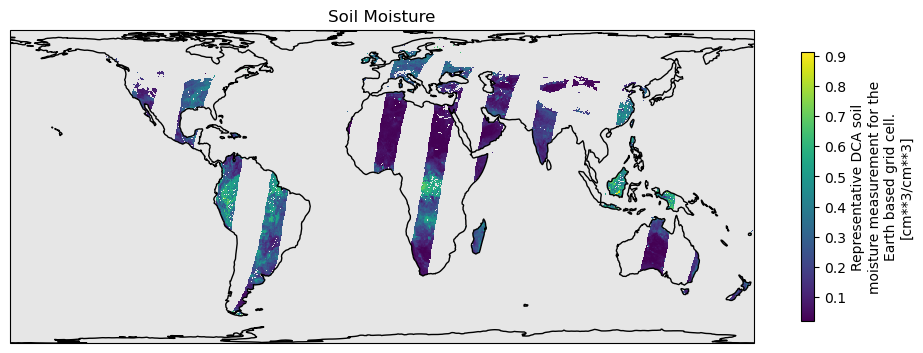

In [8]:
# EASEGrid2 = ccrs.epsg(CRS.from_epsg(6933).to_epsg())
EASEGrid2 = ccrs.epsg(6933)

p = dt["Soil_Moisture_Retrieval_Data_AM"].soil_moisture.plot(
    subplot_kws=dict(projection=EASEGrid2, facecolor="0.9"),
    transform=EASEGrid2,
    cbar_kwargs=dict(shrink=0.5),
    figsize=(12,7),
)
p.axes.coastlines()
p.axes.set_title('Soil Moisture');

### Analyze a time-series of soil moisture

Now that we know how to open one file as a `xarray.DataTree` lets open multiple open multiple files to create a time series for March 2017.  We will plot the time mean for March and also plot a time series of spatially averaged soil moisture for a region in Colorado.

#### Read multiple files as a time series

Currently, `xarray.open_datatree` can only open a single file as a `xarray.DataTree` object, so we have to use a different strategy to open a time series of files.  Ideally, the alternative strategy would be to use `xarray.open_mfdataset` which is designed to load data from multiple files into a single dataset.  However, we need a coordinate variable to concatenate on.  For a time series, this is a time.  The SMAP files do not have a time dimension.  The time is in the filename instead.

Our data access strategy is to open each file individually using a function `preprocess_file` and then concatenate all the `xarray.Dataset` from this preprocessing step into a single large `Dataset`.  `preprocess_file` gets the timestamp for the data from the filename, opens the file, renames the dimensions as we did above, and adds `x`, `y`, and `time` coordinates.  the `xarray.concat` function is used to concatenate the files along the time dimension.

```{note}
If you creating your own NetCDF4 or HDF5 files, it is good practice to add a time dimension, even if data are for a singe timestep.  This allows tools such as `xarray` to create time series of data efficiently.
```

In [9]:
def preprocess_file(f, x, y):

    time_string = f.stem.split("_")[4]  # Get date string from filename
    time = datetime.datetime.strptime(time_string, "%Y%m%d")  # Create datetime object
    
    ds = xr.open_dataset(f, 
                     group="Soil_Moisture_Retrieval_Data_AM", 
                     # phony_dims="sort",
                     decode_timedelta=False)
    
    ds = ds.rename_dims({
          'phony_dim_0': 'y', 
          'phony_dim_1': 'x', 
          'phony_dim_2': 'igbp_class'
      })

    # add coordinates
    ds["x"] = x  # x and y are defined above
    ds["y"] = y
    ds["time"] = [time]
    
    return ds
    
datasets = [preprocess_file(f, x, y) for f in filelist]  # Use x and y from earlier calculations

ds = xr.concat(datasets, dim="time")

ds

/tmp/ipykernel_245681/1621649018.py:26: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.concat(datasets, dim="time")


<xarray.Dataset> Size: 4GB
Dimensions:                      (time: 31, y: 406, x: 964, igbp_class: 3)
Coordinates:
  * x                            (x) float64 8kB -1.735e+07 ... 1.735e+07
  * y                            (y) float64 3kB 7.297e+06 ... -7.297e+06
  * time                         (time) datetime64[ns] 248B 2017-03-01 ... 20...
Dimensions without coordinates: igbp_class
Data variables: (12/53)
    EASE_column_index            (time, y, x) float32 49MB 0.0 1.0 ... 963.0
    EASE_row_index               (time, y, x) float32 49MB 0.0 0.0 ... 405.0
    albedo                       (time, y, x) float32 49MB nan nan ... 0.0 0.03
    albedo_dca                   (time, y, x) float32 49MB nan nan ... 0.0 0.03
    albedo_scah                  (time, y, x) float32 49MB nan nan ... 0.0 0.025
    albedo_scav                  (time, y, x) float32 49MB nan nan ... 0.0 0.025
    ...                           ...
    tb_v_uncorrected             (time, y, x) float32 49MB 251.9 251.7 ... 225.3
    vegetation_opacity           (time, y, x) float32 49MB nan nan ... nan nan
    vegetation_opacity_dca       (time, y, x) float32 49MB nan nan ... nan nan
    vegetation_opacity_scah      (time, y, x) float32 49MB nan nan ... nan nan
    vegetation_opacity_scav      (time, y, x) float32 49MB nan nan ... nan nan
    vegetation_water_content     (time, y, x) float32 49MB nan nan ... nan nan

#### Plot mean monthly soil moisture for March 2017

We can now use `xarray` to calculate the mean soil moisture for March 2017 and plot the data on a map.

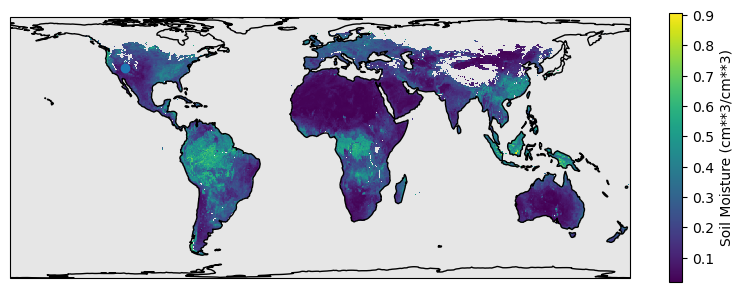

In [10]:
cbar_label = " ".join(ds.soil_moisture.name.split("_")).title() + f" ({ds.soil_moisture.attrs['units']})"

p = ds.soil_moisture.mean(dim=["time"]).plot(
    subplot_kws=dict(projection=EASEGrid2, facecolor="0.9"),
    transform=EASEGrid2,
    cbar_kwargs=dict(shrink=0.5, label=cbar_label),
    figsize=(10,7)
)
p.axes.coastlines()

p.axes.scatter(-113.5, 37.5, transform=ccrs.PlateCarree())

#### Calculate and Plot a Time series for Four Corners Region

We can use the time series of SMAP data to generate a plot of mean soil moisture from SMAP for the Four Corners of the western USA.  The region of interest is defined by the latitude and longitudes in the code-cell below.  These need to be transformed to grid coordinates in the EASE Grid 2.0 Global coordinate reference system (CRS).

There are several tools that can be used to do this.  Here we use the `transform_point` method of the `cartopy.crs`, `EASEGrid2`, we defined for creating the maps above.  This takes a longitude and a latitude for each corner of the region of interest, along with the CRS for the latitude and longitude coordinate system.

In [11]:
N_lat = 37.5
S_lat = 33.0
W_lon = -113.5
E_lon = -110.0

x1, y1 = EASEGrid2.transform_point(E_lon, S_lat, src_crs=ccrs.Geodetic())
x0, y0 = EASEGrid2.transform_point(W_lon, N_lat, src_crs=ccrs.Geodetic())

x0, x1, y0, y1

(np.float64(-10951192.808476754),
 np.float64(-10613490.827598616),
 np.float64(4457063.374682719),
 np.float64(3986270.2078663567))

We can now subset the `soil_moisture` grids along the `x` and `y` dimensions using the `.sel` method.  We then calculate a mean over these dimensions and plot the result, all within `xarray`.  The EASE Grid 2.0 CRS is an equal area projection, so grid cells do not need to be weighted before averaging them.

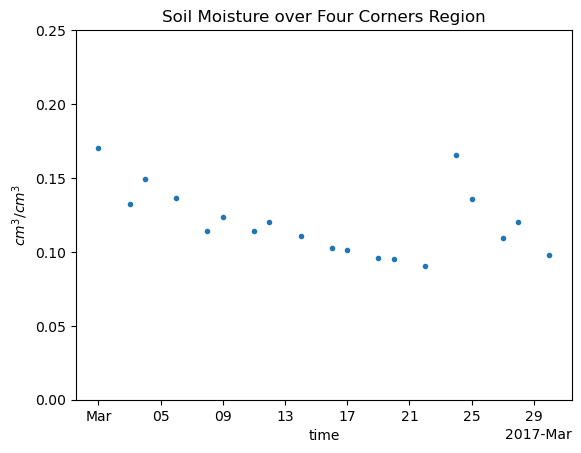

In [12]:
p = ds.soil_moisture.sel(x=slice(x0,x1), y=slice(y0,y1)).mean(dim=["x","y"]).plot(
    ls='', marker='.', ylim=(0,0.25), 
)
p[0].axes.set_ylabel(f"${ds.soil_moisture.attrs['units'].replace('**','^')}$");
p[0].axes.set_title("Soil Moisture over Four Corners Region");